In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# Preparing machine learning models for real-time scoring in production environment
### Real-time scoring considerations
* How can I check incoming raw data quality on the fly?
* How can I ensure that broken data won't break my model / API?
* How can I perform feature engineering on the fly?
### What are sklearn pipelines? How can they help solve above challenges?
### How can I create a pipeline?
### How can I write my own data preprocessors and embed them in a sklearn pipeline? [Highlight]
### [Optional] Time-based train-test split and final production-ready model training
### [Optional] Using Flask and Docker to embed your model in a production-ready REST API
### [Optional] Latency testing with Locust

# ------------------------------------------------------------------------------------------------------
# PART 0
## LOADING NECESSARY SOFTWARE PACKAGES

In [2]:
### Load necessary packages
print('Loading standard Python packages...')

# General, data handling and visualization
import platform
import os
import sys
from shutil import copyfile, copytree, rmtree
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import json
%matplotlib inline

# Data preprocessing, ML model training & validation
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics
from sklearn.externals import joblib # to save models

# Probability calibration
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# Pipelining
from sklearn.base import BaseEstimator, TransformerMixin # for definition of custom transformers
from sklearn.pipeline import Pipeline

# Datetime conversions
import datetime
import calendar

import bisect

from copy import deepcopy

# Set jupyter screen width to 100%
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)


print('Standard Python packages successfully loaded.')

Loading standard Python packages...


Standard Python packages successfully loaded.


In [3]:
### Check package versions
print('Your system type and version of key dependencies:')

Your system type and version of key dependencies:


In [4]:
print('Operating system:', platform.system())
print('OS release:', platform.release())
print('Machine:', platform.machine())
print('Platform:', platform.platform())
print('Version:', platform.version())
print()
print('Python version: {}'.format(sys.version))
print('Pandas version: {}'.format(pd.__version__))
print('Numpy version: {}'.format(np.__version__))
print('Scikit-learn version: {}'.format(sklearn.__version__))

Operating system: Linux
OS release: 4.15.0-99-generic
Machine: x86_64
Platform: Linux-4.15.0-99-generic-x86_64-with-debian-buster-sid
Version: #100-Ubuntu SMP Wed Apr 22 20:32:56 UTC 2020

Python version: 3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]
Pandas version: 0.24.2
Numpy version: 1.16.3
Scikit-learn version: 0.20.3


In [5]:
### Load helper functions
print('Importing custom helper functions...')

# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

from src.library.helper_functions import predict, validate, plot_ROC_curve, plot_precision_recall_curve

print('Helper functions imported.')

Importing custom helper functions...
Helper functions imported.


In [6]:
### Load widget class that allows the user to browse for the data file to be used
#print('Importing custom FileBrowser widget...')

#from src.library.select_file import FileBrowser 

#print('FileBrowser widget imported.')

In [7]:
"""### Load custom preprocessing transformers - to be used in the pipeline later on
print('Importing custom data preprocessors...')

from src.library.pipeline_components import WhitespaceRemover, CastToOriginalDtypes, CastToUserDtypes, CheckForUnseenValues, DfToDict
from src.library.pipeline_components import IntegerEncoder, DayOfWeekEncoder, DeviceEncoder, FeatureRemover, AgeEncoder

print('Custom preprocessors imported.')"""

"### Load custom preprocessing transformers - to be used in the pipeline later on\nprint('Importing custom data preprocessors...')\n\nfrom src.library.pipeline_components import WhitespaceRemover, CastToOriginalDtypes, CastToUserDtypes, CheckForUnseenValues, DfToDict\nfrom src.library.pipeline_components import IntegerEncoder, DayOfWeekEncoder, DeviceEncoder, FeatureRemover, AgeEncoder\n\nprint('Custom preprocessors imported.')"

In [8]:
"""### Set up the training & prediction pipeline

print('Setting up model training and prediction pipelines...')

# Create random forest classifier object
RF_clf = RandomForestClassifier(n_estimators=100, # different than default, default = 10
                                criterion='gini',
                                max_depth=None, # Changed to 100 to limit the depth of each tree..
                                min_samples_split=2,
                                min_samples_leaf=1,
                                min_weight_fraction_leaf=0.0,
                                max_features=1, # different than default, default = 'auto'
                                max_leaf_nodes=None,
                                bootstrap=True,
                                oob_score=False,
                                n_jobs=-1, # use all available cores
                                random_state=0, # define random state for reproducibility of results
                                verbose=0,
                                warm_start=False,
                                class_weight=None)

## Create pipeline - no calibration
RF_pipeline_uncalibrated = Pipeline([('whitespaceremoval', WhitespaceRemover()),
                                    ('originaldtypescasting', CastToOriginalDtypes()),
                                    ('deviceencoder', DeviceEncoder()),
                                    ('ageencoder', AgeEncoder()),
                                    ('dayofweekencoder', DayOfWeekEncoder()),
                                    ('userdtypescasting', CastToUserDtypes()),
                                    ('unseenvalueschecker', CheckForUnseenValues()),
                                    ('featureremoval', FeatureRemover()),
                                    ('dicttransformer', DfToDict()),
                                    ('ohe', DictVectorizer()),
                                    ('imputation', Imputer(missing_values='NaN', strategy='most_frequent')),
                                    ('scaling', StandardScaler(with_mean=False)),
                                    ('classifier', RF_clf)])

## Isotonic calibration
RF_pipeline_isotonic = Pipeline([('whitespaceremoval', WhitespaceRemover()),
                                    ('originaldtypescasting', CastToOriginalDtypes()),
                                    ('deviceencoder', DeviceEncoder()),
                                    ('ageencoder', AgeEncoder()),
                                    ('dayofweekencoder', DayOfWeekEncoder()),
                                    ('userdtypescasting', CastToUserDtypes()),
                                    ('unseenvalueschecker', CheckForUnseenValues()),
                                    ('featureremoval', FeatureRemover()),
                                    ('dicttransformer', DfToDict()),
                                    ('ohe', DictVectorizer()),
                                    ('imputation', Imputer(missing_values='NaN', strategy='most_frequent')),
                                    ('scaling', StandardScaler(with_mean=False)),
                                    #('classifier', RF_clf)])
                                    ('classifier', CalibratedClassifierCV(base_estimator=RF_clf, cv=2, method='isotonic'))])

## Sigmoid calibration
RF_pipeline_sigmoid = Pipeline([('whitespaceremoval', WhitespaceRemover()),
                                    ('originaldtypescasting', CastToOriginalDtypes()),
                                    ('deviceencoder', DeviceEncoder()),
                                    ('ageencoder', AgeEncoder()),
                                    ('dayofweekencoder', DayOfWeekEncoder()),
                                    ('userdtypescasting', CastToUserDtypes()),
                                    ('unseenvalueschecker', CheckForUnseenValues()),
                                    ('featureremoval', FeatureRemover()),
                                    ('dicttransformer', DfToDict()),
                                    ('ohe', DictVectorizer()),
                                    ('imputation', Imputer(missing_values='NaN', strategy='most_frequent')),
                                    ('scaling', StandardScaler(with_mean=False)),
                                    #('classifier', RF_clf)])
                                    ('classifier', CalibratedClassifierCV(base_estimator=RF_clf, cv=2, method='sigmoid'))])
                                

print('Model training and prediction pipelines set up.')"""

"### Set up the training & prediction pipeline\n\nprint('Setting up model training and prediction pipelines...')\n\n# Create random forest classifier object\nRF_clf = RandomForestClassifier(n_estimators=100, # different than default, default = 10\n                                criterion='gini',\n                                max_depth=None, # Changed to 100 to limit the depth of each tree..\n                                min_samples_split=2,\n                                min_samples_leaf=1,\n                                min_weight_fraction_leaf=0.0,\n                                max_features=1, # different than default, default = 'auto'\n                                max_leaf_nodes=None,\n                                bootstrap=True,\n                                oob_score=False,\n                                n_jobs=-1, # use all available cores\n                                random_state=0, # define random state for reproducibility of results\n              

# ------------------------------------------------------------------------------------------------------
# PART 1
## LET'S HAVE A LOOK AT THE DATA

### We will be using a modified open-source German credit scoring dataset
Original dataset is available under https://www.kaggle.com/uciml/german-credit/data

In [9]:
#print('Please select the data file that should be used for model training:')
#datafile = FileBrowser()
#datafile.widget()

In [10]:
"""# Load ORIGINAL full TMA dataset
print('Reading in selected file...')
# Uncomment the below read_csv statement to load a test sample of the data, for a test run of the notebook
#df = pd.read_csv('../data/interim/np_training_2_downsampled.csv',
#                 parse_dates=['PURCHASE_DATE', 'BIRTHDATE'],
#                 low_memory=False)

# Uncomment the below read_csv statement to load the full TMA dataset
df = pd.read_csv('../data/kaggle_german_credit_data_original_with_label.csv',
                 #sep='\t',
                 #decimal=',',
                 #parse_dates=['PURCHASE_DATE', 'BIRTHDATE'],
                 #encoding='ISO-8859-1',
                 low_memory=False)

print('File successfully read in. Analyzing...')

print('Table dimensions:')
print('Number of rows:', df.shape[0])
print('Number of columns:', df.shape[1])
print()
pd.set_option("display.max_columns", df.shape[1])
pd.set_option("display.max_rows", df.shape[1])
print('Overview of the first five table rows:')
display(df.head())
print('Overview of the last five table rows:')
display(df.head())
# print('Column datatypes:')
# print(df.dtypes)"""

'# Load ORIGINAL full TMA dataset\nprint(\'Reading in selected file...\')\n# Uncomment the below read_csv statement to load a test sample of the data, for a test run of the notebook\n#df = pd.read_csv(\'../data/interim/np_training_2_downsampled.csv\',\n#                 parse_dates=[\'PURCHASE_DATE\', \'BIRTHDATE\'],\n#                 low_memory=False)\n\n# Uncomment the below read_csv statement to load the full TMA dataset\ndf = pd.read_csv(\'../data/kaggle_german_credit_data_original_with_label.csv\',\n                 #sep=\'\t\',\n                 #decimal=\',\',\n                 #parse_dates=[\'PURCHASE_DATE\', \'BIRTHDATE\'],\n                 #encoding=\'ISO-8859-1\',\n                 low_memory=False)\n\nprint(\'File successfully read in. Analyzing...\')\n\nprint(\'Table dimensions:\')\nprint(\'Number of rows:\', df.shape[0])\nprint(\'Number of columns:\', df.shape[1])\nprint()\npd.set_option("display.max_columns", df.shape[1])\npd.set_option("display.max_rows", df.shape[1])

In [11]:
"""sns.countplot(y='Risk', data=df)
plt.show()
display(df['Risk'].value_counts())"""

"sns.countplot(y='Risk', data=df)\nplt.show()\ndisplay(df['Risk'].value_counts())"

In [12]:
"""df.drop(['Unnamed: 0'], axis=1, inplace=True)
df['Gender'] = df['Sex']
df.drop(['Sex'], axis=1, inplace=True)
df.head()"""

"df.drop(['Unnamed: 0'], axis=1, inplace=True)\ndf['Gender'] = df['Sex']\ndf.drop(['Sex'], axis=1, inplace=True)\ndf.head()"

In [13]:
"""datetime.datetime.now()"""

'datetime.datetime.now()'

In [14]:
"""df['Purchase_date'] = datetime.datetime.now()"""

"df['Purchase_date'] = datetime.datetime.now()"

In [15]:
"""def random_dates(start, end, n=1):

    start_u = start.value//10**9
    end_u = end.value//10**9

    return pd.to_datetime(np.random.randint(start_u, end_u, n), unit='s').date[0]"""

"def random_dates(start, end, n=1):\n\n    start_u = start.value//10**9\n    end_u = end.value//10**9\n\n    return pd.to_datetime(np.random.randint(start_u, end_u, n), unit='s').date[0]"

In [16]:
"""start_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime('2020-05-15')
random_dates(start_date, end_date)"""

"start_date = pd.to_datetime('2020-01-01')\nend_date = pd.to_datetime('2020-05-15')\nrandom_dates(start_date, end_date)"

In [17]:
"""df['Purchase_date'] = df.apply(lambda row : random_dates(start_date, end_date), axis=1)
df['Purchase_date'] = pd.to_datetime(df['Purchase_date'])"""

"df['Purchase_date'] = df.apply(lambda row : random_dates(start_date, end_date), axis=1)\ndf['Purchase_date'] = pd.to_datetime(df['Purchase_date'])"

In [18]:
"""def generate_birth_date(row):
    purchase_date = row['Purchase_date']
    age_years = row['Age']
    
    return purchase_date - pd.DateOffset(years=age_years)

df['Birth_date'] = df.apply(lambda row : generate_birth_date(row), axis=1)
df['Birth_date'] = pd.to_datetime(df['Birth_date'])"""

"def generate_birth_date(row):\n    purchase_date = row['Purchase_date']\n    age_years = row['Age']\n    \n    return purchase_date - pd.DateOffset(years=age_years)\n\ndf['Birth_date'] = df.apply(lambda row : generate_birth_date(row), axis=1)\ndf['Birth_date'] = pd.to_datetime(df['Birth_date'])"

In [19]:
"""import random
def allocate_device(device_lst):
    return random.choice(device_lst)"""

'import random\ndef allocate_device(device_lst):\n    return random.choice(device_lst)'

In [20]:
"""device_list = [
    'iPhone 10 Black',
    'iPhone 11 Black',
    'iPhone 10 White',
    'iPhone 11 Black',
    'iPhone 9',
    'Samsung Amazing',
    'Huawei Great',
    'Nokia Old',
    'Samsung Fantastic',
    'Huawei Fantastic',
    'Samsung Awesome',
    'Huawei Awesome',
    'Nokia Very Old',
    'Ericsson Very Old',
    'One Plus 8 128 GB',
    'OPPO Find X2 256 GB',
    'OPPO Reno 2'
]

df['Device'] = df.apply(lambda row : allocate_device(device_list), axis=1)"""

"device_list = [\n    'iPhone 10 Black',\n    'iPhone 11 Black',\n    'iPhone 10 White',\n    'iPhone 11 Black',\n    'iPhone 9',\n    'Samsung Amazing',\n    'Huawei Great',\n    'Nokia Old',\n    'Samsung Fantastic',\n    'Huawei Fantastic',\n    'Samsung Awesome',\n    'Huawei Awesome',\n    'Nokia Very Old',\n    'Ericsson Very Old',\n    'One Plus 8 128 GB',\n    'OPPO Find X2 256 GB',\n    'OPPO Reno 2'\n]\n\ndf['Device'] = df.apply(lambda row : allocate_device(device_list), axis=1)"

In [21]:
"""df.head(20)"""

'df.head(20)'

In [22]:
"""def generate_label(row):
    risk = row['Risk']
    if risk == 'good':
        return 0
    else:
        return 1

df['Risk_label'] = df.apply(lambda row : generate_label(row), axis=1)
df.head()"""

"def generate_label(row):\n    risk = row['Risk']\n    if risk == 'good':\n        return 0\n    else:\n        return 1\n\ndf['Risk_label'] = df.apply(lambda row : generate_label(row), axis=1)\ndf.head()"

In [23]:
"""df.drop(['risk_label', 'Risk'], axis=1, inplace=True)"""

"df.drop(['risk_label', 'Risk'], axis=1, inplace=True)"

In [24]:
"""df.drop(['Age'], axis=1, inplace=True)"""

"df.drop(['Age'], axis=1, inplace=True)"

In [25]:
"""df.to_csv('../data/kaggle_german_credit_data_modified.csv', index=False)"""

"df.to_csv('../data/kaggle_german_credit_data_modified.csv', index=False)"

# APPROACH 1: STANDARD, BY-THE-BOOK TRAINING OF A MACHINE LEARNING MODEL (SIMPLIFIED)

## DATA EXPLORATION
### We will be using a modified open-source German credit scoring dataset. This is a "faked" dataset, used here for demo purposes only(!)
Original dataset is available under https://www.kaggle.com/uciml/german-credit/data

Reading in selected file...
File successfully read in. Analyzing...

Table dimensions:
Number of rows: 1000
Number of columns: 12

Overview of the first five table rows:


,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Gender,Purchase_date,Birth_date,Device,Risk_label
131,2,own,little,little,6887,36,education,male,2020-03-12,1991-03-12,Samsung Fantastic,1
203,2,rent,little,little,902,12,education,male,2020-02-24,1999-02-24,Ericsson Very Old,1
50,1,own,NaN,moderate,2333,24,furniture/equipment,male,2020-04-26,1991-04-26,Nokia Old,0
585,2,rent,little,little,2039,18,furniture/equipment,female,2020-02-02,2000-02-02,Huawei Awesome,1
138,2,own,NaN,moderate,2728,15,radio/TV,male,2020-01-16,1985-01-16,iPhone 9,0



Summary of numeric features


,Job,Credit amount,Duration,Risk_label
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.904000,3271.258000,20.903000,0.300000
std,0.653614,2822.736876,12.058814,0.458487
min,0.000000,250.000000,4.000000,0.000000
25%,2.000000,1365.500000,12.000000,0.000000
50%,2.000000,2319.500000,18.000000,0.000000
75%,2.000000,3972.250000,24.000000,1.000000
max,3.000000,18424.000000,72.000000,1.000000



Summary of categorical features


,Housing,Saving accounts,Checking account,Purpose,Gender,Purchase_date,Birth_date,Device
count,1000,817,606,1000,1000,1000,1000,1000
unique,3,4,3,8,2,134,895,16
top,own,little,little,car,male,2020-05-07 00:00:00,1997-02-13 00:00:00,iPhone 11 Black
freq,713,603,274,337,690,14,4,117
first,NaN,NaN,NaN,NaN,NaN,2020-01-01 00:00:00,1945-01-09 00:00:00,NaN
last,NaN,NaN,NaN,NaN,NaN,2020-05-14 00:00:00,2001-05-11 00:00:00,NaN



Number of missing values per column:


Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Gender                0
Purchase_date         0
Birth_date            0
Device                0
Risk_label            0
dtype: int64


Number of high risk (label == 1) vs. low risk (label == 0) applicants:


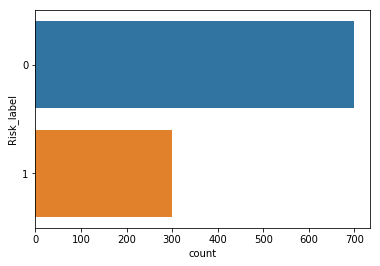

0    700
1    300
Name: Risk_label, dtype: int64


Distribution of devices used:


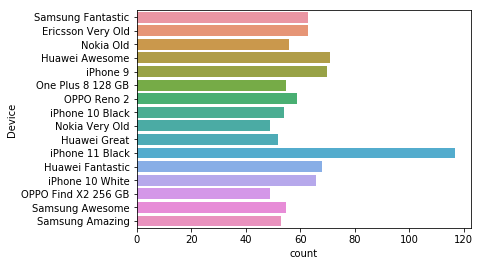


Number of unique values in the "Job" column:


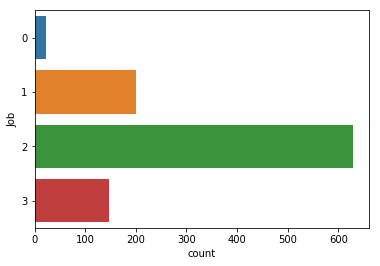

In [26]:
# Load dataset
print('Reading in selected file...')
df_original = pd.read_csv('../data/kaggle_german_credit_data_modified.csv',
                          parse_dates = ['Purchase_date', 'Birth_date'],
                          low_memory=False)

df_original = shuffle(df_original, random_state=123)
df = df_original.copy()
print('File successfully read in. Analyzing...')
print()
print('Table dimensions:')
print('Number of rows:', df.shape[0])
print('Number of columns:', df.shape[1])
print()
print('Overview of the first five table rows:')
display(df.head())
#print('Column datatypes:')
#print(df.dtypes)
print()
print('Summary of numeric features')
display(df.describe())
print()
print('Summary of categorical features')
display(df.describe(include=['object', 'datetime']))
print()
print('Number of missing values per column:')
display(df.isna().sum())
print()
print('Number of high risk (label == 1) vs. low risk (label == 0) applicants:')
sns.countplot(y='Risk_label', data=df)
plt.show()
display(df['Risk_label'].value_counts())
print()
print('Distribution of devices used:')
sns.countplot(y='Device', data=df)
plt.show()
print()
print('Number of unique values in the "Job" column:')
sns.countplot(y='Job', data=df)
plt.show()

### --> You would normally take many more data exploration steps, we skip them here for the sake of brevity.

### Your initial conclusions (example):
* I will need to deal with missing values in savings account and checking account columns
* Purchase date and birth date columns have very high cardinality, and in general dates should not be used as-is in model training. I will need to recode these columns into something useful.
* A credit risk analyst told me that the risk profile of iPhone users is different than that of people using other devices. I want to recode the Device column in iPhone vs. other devices.
* The job column looks like an integer-encoded categorical feature
* ...

## DATA CLEANING

#### Fill missing values in savings account and checking account columns

In [27]:
print('Number of missing values in savings account and checking account columns:')
display(df[['Saving accounts', 'Checking account']].isna().sum())

Number of missing values in savings account and checking account columns:


Saving accounts     183
Checking account    394
dtype: int64

In [28]:
print('Filling missing values...')
for column in df[['Saving accounts', 'Checking account']]:
    df[column] = df[column].fillna('Missing')

print('Done.')

Filling missing values...
Done.


In [29]:
print('Number of missing values in savings account and checking account columns:')
display(df[['Saving accounts', 'Checking account']].isna().sum())

Number of missing values in savings account and checking account columns:


Saving accounts     0
Checking account    0
dtype: int64

#### Cast integer-encoded "Job" column to string (all non-numeric features will be one-hot encoded at a later stage)

In [30]:
print('Dtype of the "Job" column:')
display(df['Job'].dtype)

Dtype of the "Job" column:


dtype('int64')

In [31]:
print('Casting "Job" column to string...')
df['Job'] = df['Job'].astype(str)
print('Done.')

Casting "Job" column to string...
Done.


In [32]:
print('Dtype of the "Job" column:')
display(df['Job'].dtype)

Dtype of the "Job" column:


dtype('O')

## FEATURE ENGINEERING

#### Engineer age feature (based on purchase date and date of birth)

In [33]:
def calculate_age(reference_date, birth_date):
    days_in_year = 365.2425
    try:
        age = int((pd.to_datetime(reference_date, infer_datetime_format=True) - pd.to_datetime(birth_date, infer_datetime_format=True)).days / days_in_year)
    except:
        age = None

    return age

def create_age_column(row, reference_date_column, birth_date_column):
    return calculate_age(row[reference_date_column], row[birth_date_column])

reference_date_column = 'Purchase_date'
birth_date_column = 'Birth_date'

df['Age'] = df.apply(lambda row: create_age_column(row, reference_date_column, birth_date_column), axis=1)
df.head()

,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Gender,Purchase_date,Birth_date,Device,Risk_label,Age
131,2,own,little,little,6887,36,education,male,2020-03-12,1991-03-12,Samsung Fantastic,1,29
203,2,rent,little,little,902,12,education,male,2020-02-24,1999-02-24,Ericsson Very Old,1,20
50,1,own,Missing,moderate,2333,24,furniture/equipment,male,2020-04-26,1991-04-26,Nokia Old,0,29
585,2,rent,little,little,2039,18,furniture/equipment,female,2020-02-02,2000-02-02,Huawei Awesome,1,20
138,2,own,Missing,moderate,2728,15,radio/TV,male,2020-01-16,1985-01-16,iPhone 9,0,34


#### --> Normally, you would probably additionally bin the "Age" into a handful of categories, but we are skipping this step here for the sake of brevity.

#### Engineer day of the week feature (based on purchase date) 

In [34]:
def find_day_of_week(date_string):
    recognized_date = pd.to_datetime(date_string, infer_datetime_format=True)

    return calendar.day_name[recognized_date.weekday()]

df['Purchase_weekday'] = df['Purchase_date'].map(lambda x: find_day_of_week(x))
df.head()

,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Gender,Purchase_date,Birth_date,Device,Risk_label,Age,Purchase_weekday
131,2,own,little,little,6887,36,education,male,2020-03-12,1991-03-12,Samsung Fantastic,1,29,Thursday
203,2,rent,little,little,902,12,education,male,2020-02-24,1999-02-24,Ericsson Very Old,1,20,Monday
50,1,own,Missing,moderate,2333,24,furniture/equipment,male,2020-04-26,1991-04-26,Nokia Old,0,29,Sunday
585,2,rent,little,little,2039,18,furniture/equipment,female,2020-02-02,2000-02-02,Huawei Awesome,1,20,Sunday
138,2,own,Missing,moderate,2728,15,radio/TV,male,2020-01-16,1985-01-16,iPhone 9,0,34,Thursday


#### Engineer binary "iPhone" vs. "other device" feature

In [35]:
def identify_device(string):
    if 'iphone' in string.lower():
        return 'iPhone'
    else:
        return 'Other'

df['Device'] = df['Device'].map(lambda x: identify_device(str(x)))
df.head(10)

,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Gender,Purchase_date,Birth_date,Device,Risk_label,Age,Purchase_weekday
131,2,own,little,little,6887,36,education,male,2020-03-12,1991-03-12,Other,1,29,Thursday
203,2,rent,little,little,902,12,education,male,2020-02-24,1999-02-24,Other,1,20,Monday
50,1,own,Missing,moderate,2333,24,furniture/equipment,male,2020-04-26,1991-04-26,Other,0,29,Sunday
585,2,rent,little,little,2039,18,furniture/equipment,female,2020-02-02,2000-02-02,Other,1,20,Sunday
138,2,own,Missing,moderate,2728,15,radio/TV,male,2020-01-16,1985-01-16,iPhone,0,34,Thursday
632,2,own,Missing,moderate,1444,15,radio/TV,male,2020-01-27,1997-01-27,Other,0,22,Monday
328,2,own,little,rich,4473,36,radio/TV,male,2020-01-18,1989-01-18,Other,0,30,Saturday
461,2,own,little,little,1721,15,car,male,2020-02-02,1984-02-02,Other,0,36,Sunday
924,2,own,little,little,6872,24,furniture/equipment,male,2020-01-13,1965-01-13,Other,1,54,Monday
479,2,own,little,little,1478,15,furniture/equipment,male,2020-03-18,1976-03-18,iPhone,0,44,Wednesday


## MODEL TRAINING & EVALUATION

In [36]:
print('Drop purchase date and birth date columns.')
df.drop(['Purchase_date', 'Birth_date'], axis=1, inplace=True)
df.head()

Drop purchase date and birth date columns.


,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Gender,Device,Risk_label,Age,Purchase_weekday
131,2,own,little,little,6887,36,education,male,Other,1,29,Thursday
203,2,rent,little,little,902,12,education,male,Other,1,20,Monday
50,1,own,Missing,moderate,2333,24,furniture/equipment,male,Other,0,29,Sunday
585,2,rent,little,little,2039,18,furniture/equipment,female,Other,1,20,Sunday
138,2,own,Missing,moderate,2728,15,radio/TV,male,iPhone,0,34,Thursday


#### Split the dataset into train and test sets

In [37]:
print('Split the dataset.')
# Create separate object for target variable
y = df['Risk_label']
# Create separate object for input features
X = df.drop('Risk_label', axis=1)

# Split X and y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

Split the dataset.


#### One-hot encode with DictVectorizer

In [38]:
## Convert feature df to a dict
X_train_ohe = X_train.to_dict(orient='records')
X_test_ohe = X_test.to_dict(orient='records')

# Instantiate DictVectorizer
dict_vec = DictVectorizer(sparse=False)

# apply dv_X on X_dict
X_train_ohe = dict_vec.fit_transform(X_train_ohe)
X_test_ohe = dict_vec.transform(X_test_ohe)

display(X_train.head())
display(X_train_ohe)
display(X_train_ohe.shape)
#display(dict_vec.vocabulary_)

,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Gender,Device,Age,Purchase_weekday
67,2,own,rich,moderate,1007,12,car,male,iPhone,21,Friday
899,2,own,little,little,4153,18,furniture/equipment,male,iPhone,42,Saturday
752,1,rent,moderate,moderate,841,12,business,female,Other,22,Thursday
26,1,own,little,Missing,426,6,radio/TV,male,Other,39,Sunday
159,1,own,Missing,Missing,1898,6,radio/TV,male,Other,33,Sunday


array([[21.,  0.,  0., ...,  0.,  0.,  1.],
       [42.,  0.,  1., ...,  0.,  0.,  0.],
       [22.,  0.,  0., ...,  1.,  0.,  0.],
       ...,
       [24.,  0.,  0., ...,  0.,  0.,  1.],
       [33.,  0.,  0., ...,  0.,  0.,  0.],
       [74.,  0.,  0., ...,  0.,  0.,  0.]])

(750, 38)

#### Add imputation of missing values and feature scaling

In [39]:
my_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
my_scaler = StandardScaler(with_mean=False)

X_train_ohe = my_imputer.fit_transform(X_train_ohe)
X_train_ohe = my_scaler.fit_transform(X_train_ohe)

X_test_ohe = my_imputer.transform(X_test_ohe)
X_test_ohe = my_scaler.transform(X_test_ohe)

#### Define and fit a classifier

In [40]:
# Create random forest classifier object
RF_clf = RandomForestClassifier(n_estimators=100)

In [41]:
RF_clf.fit(X_train_ohe, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

#### Evaluate the fitted classifier

area_under_curve: 0.706
accuracy: 0.740
log_loss: 0.539
precision: 0.553
recall: 0.371
specificity: 0.883
f1_score: 0.444

confusion_matrix:
[[159, 21], [44, 26]]

roc_curve:


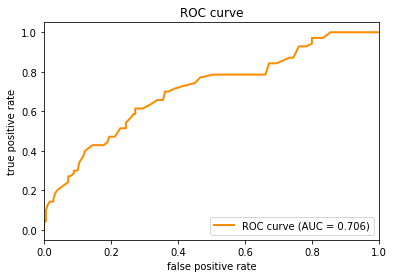


precision_recall_curve:


<Figure size 432x288 with 0 Axes>

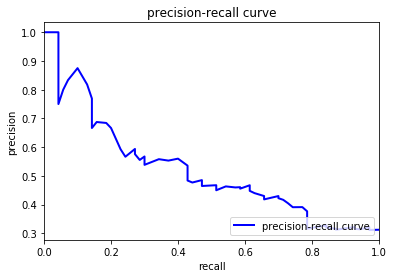

<Figure size 432x288 with 0 Axes>

In [42]:
validate(RF_clf, X_test_ohe, y_test)

#### --> Normally you would evaluate multiple feature engineering approaches, classifiers and hyperparameter settings with K-fold cross-validation / GridSearchCV / automl. We keep it simple for the sake of brevity here.

In [43]:
"""
# Create random forest classifier object
RF_clf = RandomForestClassifier(n_estimators=100, # different than default, default = 10
                                criterion='gini',
                                max_depth=None, # Changed to 100 to limit the depth of each tree..
                                min_samples_split=2,
                                min_samples_leaf=1,
                                min_weight_fraction_leaf=0.0,
                                max_features=1, # different than default, default = 'auto'
                                max_leaf_nodes=None,
                                bootstrap=True,
                                oob_score=False,
                                n_jobs=-1, # use all available cores
                                random_state=0, # define random state for reproducibility of results
                                verbose=0,
                                warm_start=False,
                                class_weight=None)

## Create pipeline - no calibration
RF_pipeline_uncalibrated = Pipeline([('whitespaceremoval', WhitespaceRemover()),
                                    ('originaldtypescasting', CastToOriginalDtypes()),
                                    ('deviceencoder', DeviceEncoder()),
                                    ('ageencoder', AgeEncoder()),
                                    ('dayofweekencoder', DayOfWeekEncoder()),
                                    ('userdtypescasting', CastToUserDtypes()),
                                    ('unseenvalueschecker', CheckForUnseenValues()),
                                    ('featureremoval', FeatureRemover()),
                                    ('dicttransformer', DfToDict()),
                                    ('ohe', DictVectorizer()),
                                    ('imputation', Imputer(missing_values='NaN', strategy='most_frequent')),
                                    ('scaling', StandardScaler(with_mean=False)),
                                    ('classifier', RF_clf)])"""

"\n# Create random forest classifier object\nRF_clf = RandomForestClassifier(n_estimators=100, # different than default, default = 10\n                                criterion='gini',\n                                max_depth=None, # Changed to 100 to limit the depth of each tree..\n                                min_samples_split=2,\n                                min_samples_leaf=1,\n                                min_weight_fraction_leaf=0.0,\n                                max_features=1, # different than default, default = 'auto'\n                                max_leaf_nodes=None,\n                                bootstrap=True,\n                                oob_score=False,\n                                n_jobs=-1, # use all available cores\n                                random_state=0, # define random state for reproducibility of results\n                                verbose=0,\n                                warm_start=False,\n                                

## HOW DO I REPRODUCE THESE STEPS IN NEAR-REAL-TIME IN THE PRODUCTION ENVIRONMENT?

In [44]:
print('At the time of prediction, the data streamed into our classifier .predict() method will look like this:')
display(df_original.iloc[:,:-1].head(1))
print('...missing values, purchase date instead of day of the week, birth date instead of age, full device model name, not one-hot encoded, etc., etc.')

At the time of prediction, the data streamed into our classifier .predict() method will look like this:


,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Gender,Purchase_date,Birth_date,Device
131,2,own,little,little,6887,36,education,male,2020-03-12,1991-03-12,Samsung Fantastic


...missing values, purchase date instead of day of the week, birth date instead of age, full device model name, not one-hot encoded, etc., etc.


In [45]:
# Utility step: create a dedicated output directory - we can skip it since we during the session we don't need to really save generated objects and code
model_training_timestamp = '{:%Y-%b-%d_%H-%M-%S}'.format(datetime.datetime.now())
print('Model training completed on ', model_training_timestamp,'.')
print('Creating dedicated output directory...')
dirName = '../output/%s/' % (model_training_timestamp)
 
try:
    # Create target directory
    os.mkdir(dirName)
    os.mkdir(dirName+'one_by_one')
    os.mkdir(dirName+'standard_pipeline')
    os.mkdir(dirName+'e2e_pipeline')
    print("Directory " , dirName ,  "successfully created.")
except FileExistsError:
    print("ERROR: Directory " , dirName ,  "already exists!")

Model training completed on  2020-May-19_21-56-29 .
Creating dedicated output directory...
Directory  ../output/2020-May-19_21-56-29/ successfully created.


### Method 1: Reproduce all above steps one by one in the production code (NOT RECOMMENDED)

In [46]:
# Save all the fitted preprocessors to a directory
print('Saving all fitted preprecessors...')
joblib.dump(dict_vec, dirName+'one_by_one/dict_vec.pkl')
joblib.dump(my_imputer, dirName+'one_by_one/my_imputer.pkl')
joblib.dump(my_scaler, dirName+'one_by_one/my_scaler.pkl')
joblib.dump(RF_clf, dirName+'one_by_one/RF_clf.pkl')
print('Saved in ', dirName, '.')

Saving all fitted preprecessors...
Saved in  ../output/2020-May-19_21-56-29/ .


In [47]:
### Create a code snippet / .py module that does all the preprocessing and prediction in one go - something like the code below.

# Read in saved objects from the production "output" directory
dict_vec_prod = joblib.load(dirName+'one_by_one/dict_vec.pkl')
my_imputer_prod = joblib.load(dirName+'one_by_one/my_imputer.pkl')
my_scaler_prod = joblib.load(dirName+'one_by_one/my_scaler.pkl')
RF_clf_prod = joblib.load(dirName+'one_by_one/RF_clf.pkl')

# Define a predict function with all the preprocessing steps
def predict(df):
    print('Filling missing values...')
    for column in df[['Saving accounts', 'Checking account']]:
        df[column] = df[column].fillna('Missing')
    
    print('Done.')
    
    print('Casting "Job" column to string...')
    df['Job'] = df['Job'].astype(str)
    print('Done.')
    
    print('Engineering "Age" feature...') # Don't forget to import create_age_column() and calculate_age() methods into production environment too ;)
    reference_date_column = 'Purchase_date'
    birth_date_column = 'Birth_date'
    df['Age'] = df.apply(lambda row: create_age_column(row, reference_date_column, birth_date_column), axis=1)
    print('Done.')
    
    print('Engineering day of week feature...')
    df['Purchase_weekday'] = df['Purchase_date'].map(lambda x: find_day_of_week(x))
    print('Done.')
    
    print('Engineering binary iPhone-Other device feature...')
    df['Device'] = df['Device'].map(lambda x: identify_device(str(x)))
    print('Done.')
    
    print('Dropping purchase date and birth date columns.')
    df.drop(['Purchase_date', 'Birth_date'], axis=1, inplace=True)
    print('Done.')
    
    print('One-hot encoding...')
    df_ohe = df.to_dict(orient='records')
    df_ohe = dict_vec_prod.transform(df_ohe)
    print('Done.')
    
    print('Imputation of missing values and feature scaling...')
    df_ohe = my_imputer_prod.transform(df_ohe)
    df_ohe = my_scaler_prod.transform(df_ohe)
    print('Done.')
    
    print('Making a prediction...')
    pred = RF_clf_prod.predict_proba(df_ohe)
    print()
    
    return pred


def calculate_age(reference_date, birth_date):
    days_in_year = 365.2425
    try:
        age = int((pd.to_datetime(reference_date, infer_datetime_format=True) - pd.to_datetime(birth_date, infer_datetime_format=True)).days / days_in_year)
    except:
        age = None

    return age


def create_age_column(row, reference_date_column, birth_date_column):
    return calculate_age(row[reference_date_column], row[birth_date_column])


def find_day_of_week(date_string):
    recognized_date = pd.to_datetime(date_string, infer_datetime_format=True)

    return calendar.day_name[recognized_date.weekday()]


def identify_device(string):
    if 'iphone' in string.lower():
        return 'iPhone'
    else:
        return 'Other'

#### Let's try to make a prediction. Will it work?

In [48]:
print('Let\'s try to make a prediction. Will it work?')
input_data = df_original.iloc[:,:-1].head(1)
print('Predicted probabilities:', predict(input_data))
print('It worked!')

Let's try to make a prediction. Will it work?
Filling missing values...
Done.
Casting "Job" column to string...
Done.
Engineering "Age" feature...
Done.
Engineering day of week feature...
Done.
Engineering binary iPhone-Other device feature...
Done.
Dropping purchase date and birth date columns.
Done.
One-hot encoding...
Done.
Imputation of missing values and feature scaling...
Done.
Making a prediction...

Predicted probabilities: [[0.06 0.94]]
It worked!


#### It worked. However, the above approach is a bad idea. Here's why:
* You need to maintain the same code in two places - it's easy to make mistakes and lose consistency between the two.
* You need to explain a lot to developers deploying and maintaining your code
* The deployment team might modify your code (intentionally or unintentionally)
* You directly reveal the entire feature engineering and model tuning know-how to anyone who has access to your code
* ...

--------

### Method 2: Use sklearn pipeline to package the standard sklearn preprocessors into a single "model pipeline" object (SLIGHTLY BETTER, BUT STILL NOT GREAT...)

According to sklearn documentation (https://scikit-learn.org/stable/modules/compose.html#pipeline-chaining-estimators):

**Pipeline** can be used to **chain multiple estimators into one**. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

**Convenience and encapsulation**
* You only have to call fit and predict once on your data to fit a whole sequence of estimators.

**Joint parameter selection**
* You can grid search over parameters of all estimators in the pipeline at once.

**Safety**
* Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

Sklearn pipeline **works out of the box for preprocessors included in the sklearn library**, such as DictVectorizer(), Imputer() or StandardScaler(), and many others.

Let's give it a try!

#### Define pipeline steps

In [49]:
# We can chain together the last four steps of our "predict" workflow into a single pipeline like this:
standard_pipeline = Pipeline([('ohe', DictVectorizer()),
                              ('imputation', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                              ('scaling', StandardScaler(with_mean=False)),
                              ('classifier', RF_clf)])

#### Fit (train) the pipeline on the training set

In [50]:
# We can then fit (train) the pipeline on our training data - directly after having done the train/test split:
standard_pipeline.fit(X_train.to_dict(orient='records'), y_train)

Pipeline(memory=None,
     steps=[('ohe', DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
        sparse=True)), ('imputation', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='most_frequent', verbose=0)), ('scaling', StandardScaler(copy=True, with_mean=False, with_std=Tru...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

#### Evaluate the pipeline on the test set

area_under_curve: 0.715
accuracy: 0.756
log_loss: 0.665
precision: 0.600
recall: 0.386
specificity: 0.900
f1_score: 0.470

confusion_matrix:
[[162, 18], [43, 27]]

roc_curve:


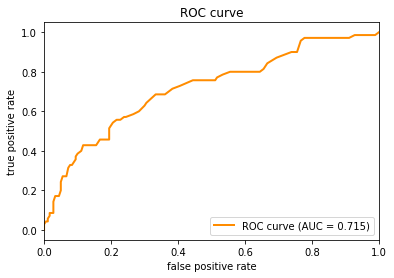


precision_recall_curve:


<Figure size 432x288 with 0 Axes>

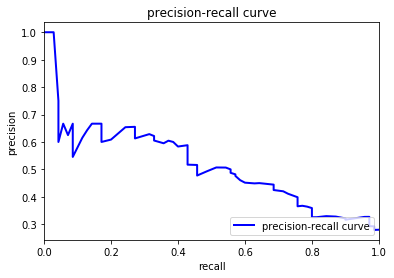

<Figure size 432x288 with 0 Axes>

In [51]:
validate(standard_pipeline, X_test.to_dict(orient='records'), y_test)

#### We now only need to save one object instead of four

In [52]:
# Save the fitted pipeline to a directory
print('Saving the fitted pipeline...')
joblib.dump(standard_pipeline, dirName+'standard_pipeline/standard_pipeline.pkl')
print('Saved in ', dirName, '.')

Saving the fitted pipeline...
Saved in  ../output/2020-May-19_21-56-29/ .


#### We can also shorten our predict() function

In [53]:
### Create a code snippet / .py module that does all the preprocessing and prediction in one go - something like the code below.

# Read in saved objects from the production "output" directory
standard_pipeline_prod = joblib.load(dirName+'standard_pipeline/standard_pipeline.pkl')

# Define a predict function with all the preprocessing steps
def predict_standard_pipeline(df):
    print('Filling missing values...')
    for column in df[['Saving accounts', 'Checking account']]:
        df[column] = df[column].fillna('Missing')
    
    print('Done.')
    
    print('Casting "Job" column to string...')
    df['Job'] = df['Job'].astype(str)
    print('Done.')
    
    print('Engineering "Age" feature...') # Don't forget to import create_age_column() and calculate_age() methods into production environment too ;)
    reference_date_column = 'Purchase_date'
    birth_date_column = 'Birth_date'
    df['Age'] = df.apply(lambda row: create_age_column(row, reference_date_column, birth_date_column), axis=1)
    print('Done.')
    
    print('Engineering day of week feature...')
    df['Purchase_weekday'] = df['Purchase_date'].map(lambda x: find_day_of_week(x))
    print('Done.')
    
    print('Engineering binary iPhone-Other device feature...')
    df['Device'] = df['Device'].map(lambda x: identify_device(str(x)))
    print('Done.')
    
    print('Dropping purchase date and birth date columns.')
    df.drop(['Purchase_date', 'Birth_date'], axis=1, inplace=True)
    print('Done.')
    
    #print('One-hot encoding...')
    #df_ohe = df.to_dict(orient='records')
    #df_ohe = dict_vec_prod.transform(df_ohe)
    #print('Done.')
    
    #print('Imputation of missing values and feature scaling...')
    #df_ohe = my_imputer_prod.transform(df_ohe)
    #df_ohe = my_scaler_prod.transform(df_ohe)
    #print('Done.')
    
    print('Making a prediction...')
    pred = standard_pipeline_prod.predict_proba(df.to_dict(orient='records'))
    print()
    
    return pred


def calculate_age(reference_date, birth_date):
    days_in_year = 365.2425
    try:
        age = int((pd.to_datetime(reference_date, infer_datetime_format=True) - pd.to_datetime(birth_date, infer_datetime_format=True)).days / days_in_year)
    except:
        age = None

    return age


def create_age_column(row, reference_date_column, birth_date_column):
    return calculate_age(row[reference_date_column], row[birth_date_column])


def find_day_of_week(date_string):
    recognized_date = pd.to_datetime(date_string, infer_datetime_format=True)

    return calendar.day_name[recognized_date.weekday()]


def identify_device(string):
    if 'iphone' in string.lower():
        return 'iPhone'
    else:
        return 'Other'

#### Does it work?

In [54]:
print('Let\'s try to make a prediction. Will it work?')
input_data = df_original.iloc[:,:-1].head(1)
print('Predicted probabilities:', predict_standard_pipeline(input_data))
print('It worked!')

Let's try to make a prediction. Will it work?
Filling missing values...
Done.
Casting "Job" column to string...
Done.
Engineering "Age" feature...
Done.
Engineering day of week feature...
Done.
Engineering binary iPhone-Other device feature...
Done.
Dropping purchase date and birth date columns.
Done.
Making a prediction...

Predicted probabilities: [[0.09 0.91]]
It worked!


#### We still have to maintain data cleaning and feature engineering code in two separate places though.
#### Can we somehow embed our customized data cleaning and feature engineering steps into an sklearn pipeline?
#### Yes, we can!
----------

### Method 3: Package data cleaning, feature engineering, preprocessing and final classifier into one single pipeline (MUCH BETTER!)

#### We need to somehow package the following steps into a pipeline object:
* Filling missing values in the categorical "saving accounts" and "checking account" columns
* Casting "Job" column to string
* Engineering "Age" feature
* Engineering "Day of week" feature
* Engineering binary iPhone-Other device feature
* Dropping purchase date and birth date columns

#### --> We need to code up our own custom transfomer classes, which can be instantiated and included as objects in an sklearn pipeline

#### In practice, it's less difficult than it sounds. Each of our classes needs the following:
#### --> inherit from sklearn base `BaseEstimator` and `TransformerMixin` classes (you don't need to understand how these base classes work in detail)
#### --> have its own `fit()` and `transform()` methods

Let's give it a try!

In [55]:
from sklearn.base import BaseEstimator, TransformerMixin

# Custom transformer for filling missing values in the categorical "saving accounts" and "checking account" columns
class ḾissingValFiller(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.cols_to_fill = None

    def fit(self, features_df, labels_df=None, columns_to_fill=None):
        if columns_to_fill is None:
            self.cols_to_fill = ['Saving accounts', 'Checking account']
        else:
            self.cols_to_fill = columns_to_fill

        return self

    def transform(self, features_df):
        transformed_df = features_df.copy()
        for column in transformed_df[self.cols_to_fill]:
            transformed_df[column] = transformed_df[column].fillna('Missing')

        return transformed_df

#### Let's test it on some input

In [56]:
input_data = df_original.iloc[:,:-1].head(1)
print('Original data:')
display(input_data)

test_filler = ḾissingValFiller()
test_filler.fit(input_data)
transformed_input_data = test_filler.transform(input_data)

print('Transformed data:')
display(transformed_input_data)

Original data:


,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Gender,Purchase_date,Birth_date,Device
131,2,own,little,little,6887,36,education,male,2020-03-12,1991-03-12,Samsung Fantastic


Transformed data:


,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Gender,Purchase_date,Birth_date,Device
131,2,own,little,little,6887,36,education,male,2020-03-12,1991-03-12,Samsung Fantastic


#### Great. Now let's code up the rest of the custom transformers!

In [57]:
# Custom transformer for casting "Job" column to string
class StringCaster(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.cols_to_cast = None

    def fit(self, features_df, labels_df=None, columns_to_cast=None):
        if columns_to_cast is None:
            self.cols_to_cast = ['Job']
        else:
            self.cols_to_cast = columns_to_cast

        return self

    def transform(self, features_df):
        transformed_df = features_df.copy()
        for column in transformed_df[self.cols_to_cast]:
            transformed_df[column] = transformed_df[column].astype(str)

        return transformed_df

# Custom transformer for engineering "Age" feature
class AgeEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.reference_date_column = None
        self.birth_date_column = None

    def fit(self, features_df, labels_df=None, r_date_col=None, b_date_col=None):
        if r_date_col is None or b_date_col is None:
            self.reference_date_column = 'Purchase_date'
            self.birth_date_column = 'Birth_date'
        else:
            self.reference_date_column = r_date_col
            self.birth_date_column = b_date_col

        return self

    def transform(self, features_df):
        transformed_df = features_df.copy()
        transformed_df['Age'] = transformed_df.apply(lambda row: self.create_age_column(row), axis=1)
        transformed_df.drop([self.birth_date_column], axis=1, inplace=True)

        return transformed_df

    def calculate_age(self, referenceDate, birthDate):
        days_in_year = 365.2425
        try:
            age = int((pd.to_datetime(referenceDate, infer_datetime_format=True) - pd.to_datetime(str(birthDate), infer_datetime_format=True)).days / days_in_year)
        except:
            age = None

        return age

    def create_age_column(self, row):
        return self.calculate_age(row[self.reference_date_column], row[self.birth_date_column])


# Customer transformer for engineering "Day of week" feature
class DayOfWeekEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.date_column = None

    def fit(self, features_df, labels_df=None, date_col=None):
        if date_col is None:
            self.date_column = 'Purchase_date'
        else:
            self.date_column = date_col

        return self

    def transform(self, features_df):
        transformed_df = features_df.copy()
        transformed_df.loc[:, self.date_column] = transformed_df[self.date_column].map(lambda x: self.find_day_of_week(x))
        transformed_df.drop([self.date_column], axis=1, inplace=True)

        return transformed_df

    def find_day_of_week(self, string):
        recognized_date = pd.to_datetime(string, infer_datetime_format=True)

        return calendar.day_name[recognized_date.weekday()]


# Custom transformer for engineering binary iPhone-Other device feature
class DeviceEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.device_column = None

    def fit(self, features_df, labels_df=None, device_col=None):
        if device_col is None:
            self.device_column = 'Device'
        else:
            self.device_column = device_col

        return self

    def transform(self, features_df):
        transformed_df = features_df.copy()
        transformed_df.loc[:, self.device_column] = transformed_df[self.device_column].map(
            lambda x: self.identify_device(str(x)))

        return transformed_df

    def identify_device(self, string):
        if 'iphone' in string.lower():
            return 'iPhone'
        else:
            return 'Other'

#### Let's build and test our custom preprocessing pipeline

In [58]:
test_preprocessing_pipeline = Pipeline([
    ('value_filler', ḾissingValFiller()),
    ('string_caster', StringCaster()),
    ('age_encoder', AgeEncoder()),
    ('day_of_week_encoder', DayOfWeekEncoder()),
    ('device_encoder', DeviceEncoder())
])

input_data = df_original.iloc[:,:-1].head(1)
print('Original data:')
display(input_data)

test_preprocessing_pipeline.fit(input_data)
transformed_input_data = test_preprocessing_pipeline.transform(input_data)

print('Transformed data:')
display(transformed_input_data)
print()
print('It works!')

Original data:


,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Gender,Purchase_date,Birth_date,Device
131,2,own,little,little,6887,36,education,male,2020-03-12,1991-03-12,Samsung Fantastic


Transformed data:


,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Gender,Device,Age
131,2,own,little,little,6887,36,education,male,Other,29



It works!


## HOW ABOUT ADDITIONAL ERROR HANDLING ON THE FLY?

#### Two sample production deployment errors / issues:

#### --> string data is entered with a preceding or trailing whitespaces, e.g. " iPhone" instead of "iPhone"

#### --> data sent to the API (e.g. in json format) has a different type than the original training data (e.g. integer instead of float, string intead of integer, etc.) 

#### Luckily, we can code up custom transformers to deal with these (and many other) issues!

In [59]:
# Transformer for preceding and trailing whitespaces
class WhitespaceRemover(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def remove_whitespace(self, features_df):
        for col in features_df:
            if features_df[col].dtype == 'object':
                features_df[col] = features_df[col].str.strip()
        return features_df

    def fit(self, features_df=None, labels_df=None):
        return self

    def transform(self, features_df):
        transformed_df = features_df.copy()
        transformed_df = self.remove_whitespace(transformed_df)
        return transformed_df


# Transformer for casting into pandas automatically recognized dtypes
class OriginalDtypesCaster(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.column_types = {}

    def fit(self, features_df, labels_df=None):
        dtypes = features_df.dtypes
        dtypes_col = dtypes.index
        dtypes_type = [i.name for i in dtypes.values]
        self.column_types = dict(zip(dtypes_col, dtypes_type))

        return self

    def transform(self, features_df):
        transformed_df = features_df.copy()
        transformed_df = transformed_df.astype(self.column_types)

        return transformed_df

## LET'S BUILD OUR FINAL E2E PIPELINE

#### Before doing so, we need to define one more utility transformer class...

In [60]:
# Transformer for transforming df to a dict (needed input format for DictVectorizer)
class DfDict(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, features_df, labels_df=None):
        return self

    def transform(self, features_df):
        return features_df.to_dict('records')

In [61]:
# Create separate object for target variable
y = df_original['Risk_label']
# Create separate object for input features
X = df_original.drop('Risk_label', axis=1)

# Split X and y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

#### Definining the final e2e pipeline consisting of 12 steps - 7 of which are our own custom transformers

In [62]:
e2e_pipeline = Pipeline([
    ('whitespace_remover', WhitespaceRemover()),
    ('original_dtypes_caster', OriginalDtypesCaster()),
    ('value_filler', ḾissingValFiller()),
    ('string_caster', StringCaster()),
    ('age_encoder', AgeEncoder()),
    ('day_of_week_encoder', DayOfWeekEncoder()),
    ('device_encoder', DeviceEncoder()),
    ('df_dict', DfDict()),
    ('dict_vec', DictVectorizer()),
    ('imputation', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('scaling', StandardScaler(with_mean=False)),
    ('classifier', RF_clf)
])

In [63]:
print('Fitting the pipeline...')
# We can then fit (train) the pipeline on our training data - directly after having done the train/test split:
e2e_pipeline.fit(X_train, y_train)
print('Done.')

Fitting the pipeline...
Done.


Evaluation metrics:
area_under_curve: 0.715
accuracy: 0.728
log_loss: 0.543
precision: 0.518
recall: 0.414
specificity: 0.850
f1_score: 0.460

confusion_matrix:
[[153, 27], [41, 29]]

roc_curve:


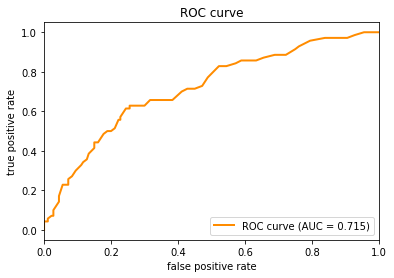


precision_recall_curve:


<Figure size 432x288 with 0 Axes>

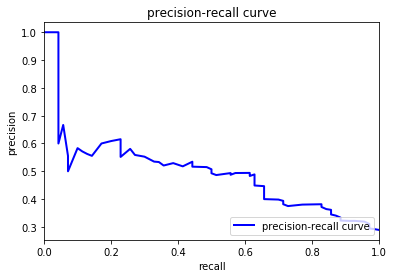

<Figure size 432x288 with 0 Axes>

In [64]:
print('Evaluation metrics:')
validate(e2e_pipeline, X_test, y_test)

## [OPTIONAL / HOMEWORK] PACKAGE YOUR PIPELINE INTO A REST API WITH FLASK AND DOCKER

In [ ]:
#pd.to_datetime(df['BIRTHDATE'].replace('nan', np.nan))
#df['BIRTHDATE'].sort_values(ascending=False).replace('nan', np.nan).head(14270)
#df.loc[df['BIRTHDATE'] == '01.07.50']

#for index, row in df.iterrows():
#    try:
#        pd.to_datetime(row['BIRTHDATE'])
#    except:
#        print(index)
#        print(row)

In [ ]:
#from sklearn.utils import resample
#df_downsampled = resample(df, n_samples=10000, replace=False, random_state=0)
#df_downsampled.to_csv('../data/interim/np_training_2_downsampled.csv', index=False)

## STEP 1
### Check for and remove duplicates

In [ ]:
# Check for duplicates
# Select duplicate rows except first occurrence based on all columns

print('Checking for duplicates...')
duplicateRowsDF = df[df.duplicated()]
if duplicateRowsDF.shape[0] == 0:
    print("Good news - no duplicates found.")
else:
    print('Duplicate rows found!')
    print('Number of duplicate rows:', duplicateRowsDF.shape[0])
    duplicateRowsDF = df[df.duplicated(keep=False)]
    duplicateRowsIndices = duplicateRowsDF.index
    #duplicateRowsIndices = duplicateRowsDF.groupby(duplicateRowsDF.columns.tolist()).apply(lambda x: tuple(x.index)).tolist()
    print('Indices of duplicate rows:')
    print(duplicateRowsIndices)
    print('Removing duplicate rows except for the first occurrence...')
    df.drop_duplicates(subset=None, keep='first', inplace=True)
    print('Done.')
    print('After removing duplicates, the table now has', df.shape[0], 'rows.')

In [ ]:
# TODO: Potentially add some more sanity checks here

## STEP 2
### Remove customers who didn't accept the offer / didn't sign the contract

In [ ]:
# Count customers per status
print('Checking what customer status is available in the data - overview of potential status codes:')
print('5 = zurückgelegt (customer did not accept the offer / did not sign the contract')
print('15 = abgelehnt (customer REJECTED)')
print('100, 110 = freigeschalten (customer ACCEPTED)')
print('75 = ?')
sns.countplot(y="STATUS_ID", data=df)
plt.show()
display(df['STATUS_ID'].value_counts())

In [ ]:
# Remove status "5" customers (status == 5) and ALSO status == 75
print('Removing customers with status == 5 and status == 75...')
df_relevant = df[~df['STATUS_ID'].isin([5, 75])].copy()

# Count customers per status
print('Overview of the status codes after removing 5 and 75:')
sns.countplot(y="STATUS_ID", data=df_relevant)
plt.show()
display(df_relevant['STATUS_ID'].value_counts())

## STEP 3
### Remove labels for the rejected customers (critical!)

In [ ]:
## Remove labels for the rejected customers
print('Original number of defaulters and non-defaulters:')
display(df_relevant['NEVERPAYER'].value_counts())
print('Removing labels for rejected customers...')
df_relevant_empty_labels = df_relevant.copy()
df_relevant_empty_labels['NEVERPAYER'] = np.where(df_relevant_empty_labels['STATUS_ID']==15, np.nan, df_relevant_empty_labels['NEVERPAYER'])
print('Number of defaulters and non-defaulters after ensuring rejected customers have empty label values:')
display(df_relevant_empty_labels['NEVERPAYER'].value_counts())

## STEP 4
### Create "BIRTH_MONTH" column - based on the "BIRTHDATE" column - to support column name and to format known to CRIF

In [ ]:
df_relevant_empty_labels['BIRTHDATE'] = pd.to_datetime(df_relevant_empty_labels['BIRTHDATE'])
#df['BIRTHDATE'].sort_values(ascending=False).replace('nan', np.nan).head(14270)
#df.loc[df['BIRTHDATE'] == '01.07.50']

#for index, row in df.iterrows():
#   try:
#        pd.to_datetime(row['BIRTHDATE'])
#    except:
#        print(index)
#        print(row)

In [ ]:
#df_relevant_empty_labels.info()

In [ ]:
print('Creating the BIRTH_MONTH column in format YYYY.MM instead of YYYY-MM-DD...')
df_relevant_empty_labels['BIRTH_MONTH'] = df_relevant_empty_labels['BIRTHDATE'].map(lambda x: (100*x.year + x.month)/100)
print('Done.')
print('Overview of first 5 rows including the new BIRTH_MONTH column')
display(df_relevant_empty_labels.head())

## STEP 5
### Add "TAC" column - which is not available in the current data, but will be used in the future and is required as an input by CRIF. This column will be filled with a dummy value.

In [ ]:
print('Adding "TAC" column and filling it with dummy data...')
df_relevant_empty_labels.loc[:, 'TAC'] = '35602508'
print('Done.')
print('Overview of first 5 rows including the new TAC column')
display(df_relevant_empty_labels.head())

## STEP 6
### Selecting columns which should be used for model training, i.e. are available in CRIF production environment

In [ ]:
print('Selecting columns...')
df_final_tool_input = df_relevant_empty_labels[['AKZ', # Erweiterung
                                               'DEVICE_PRICE', # Erweiterung
                                               'MNP_YN', # Erweiterung
                                               'COUNTRY', # CRIF
                                               'IDENTIFICATION_TYPE', # CRIF
                                               #'CNT_NOFEE_OPTIONS', # NOT ON LIST
                                               #'INSTALLMENT_TYPE', # NOT ON LIST
                                               'ISO', # CRIF
                                               #'CNT_FEE_OPTIONS', # NOT ON LIST
                                               'BIN', # CRIF
                                               'ZIP', # CRIF
                                               'GENDER', # CRIF
                                               #'KAUTION', # gestrichen
                                               'PURCHASE_HOUR', # Erweiterung
                                               'BILL_ONLINE_YN', # Erweiterung
                                               #'VALUE_NONREC_FEE', # NOT ON LIST
                                               'LIABILITY', # Erweiterung
                                               'TARIF_FEE', # Erweiterung
                                               'PURCHASE_DATE', # Erweiterung - NO PREDICTIVE VALUE IN THIS FORMAT, TOO MANY UNIQUE VALUES
                                               'BIRTH_MONTH', # CRIF, TO BE CLARIFIED, format is just the month number
                                               #'BIRTHDATE', # NOT ON LIST, TO BE CLARIFIED, format is a full date (not year)
                                               'STATUS_ID', # gestrichen, but we keep it for benchmarking purposes
                                               'MVD_MONTHS', # Erweiterung
                                               #'CNT_INSURANCE', # NOT ON LIST
                                               'DEALER_CODE', # CRIF
                                               #'VALUE_INSURANCE_FEE', # NOT ON LIST
                                               #'SIMLOCK_FLAG', # NOT ON LIST
                                               'DEVICE_MODEL_TYPE', # Erweiterung
                                               'SEGMENT_TARIF', # Erweiterung
                                               'TARIF_ID', # CRIF
                                               #'CNT_INTERLOCK', # NOT ON LIST
                                               'MEMORY_SIZE', # Erweiterung
                                               'VOLLJAEHRIG', # CRIF
                                               'AUSWEISVORH', # CRIF
                                               'CITY', # CRIF - think about some smart encoding here
                                               #'VALUE_RECURRING_FEE', # NOT ON LIST
                                               #'CRIF_DECISION', # NOT ON LIST
                                               'KLAX_MAX_UMSTEIGER_PRE2POST', # Erweiterung
                                               'PAYMENT', # CRIF
                                               'DEVICE_INFO', # Erweiterung - consider smart encoding or removing
                                               'REDUKTION', # Erweiterung
                                               'CRIF_SCORE', # CRIF
                                               'CONTRACT_INFO', # Erweiterung
                                               'BRAND', # CRIF
                                               'DEPOSIT', # Erweiterung
                                               'NEVERPAYER', # LABEL
                                               'TAC']].copy() # New colunn with dummy data - column required by CRIF

print('Done.')
print('Final table with only columns that will be used for model training - first five rows:')
display(df_final_tool_input.head())

## STEP 7
### Specifying decision column and label column

In [ ]:
print('Specifying decision column and label column...')
## Decision column assumed to not exist unless specified by the user
decision_column = None
label_column = None

## User specifies which column is the decision column
decision_column = 'STATUS_ID'
label_column = 'NEVERPAYER'
print('Done.')

In [ ]:
# Create "lean" dataframe that will be used in next steps
#print('Creating lean dataframe including only columns needed for model training and evaluation...')
#input_cols.extend(decision_columns)
#input_cols.extend([label_column])
#df_relevant = df[input_cols].copy()
#print('Done.')

# TODO: for model retraining, 
# a cross-check whether column names and dtypes are the same as in the first training should be included

In [ ]:
### Removing completely empty columns:
# Number of missing values per column
#print('Checking whether there are empty columns...')
#completely_empty_cols = []
#for index, value in df.isnull().sum().iteritems():
#    if value == df.shape[0]:
#        completely_empty_cols.append(index)
        
#print('Completely empty columns found. They are going to be removed:')
#print(completely_empty_cols)
#print('Removing empty columns...')
#df_relevant.drop(completely_empty_cols, inplace=True, axis=1)
#print('Done.')

In [ ]:
#display(df_relevant.head())

# ------------------------------------------------------------------------------------------------------
# PART 2
## DATA PREPROCESSING AND MODEL TRAINING

In [ ]:
#df_final_tool_input = df_relevant.copy()
print('Overview of the number of defaulters (label = 1) vs good customers (label = 0)')
sns.countplot(y=label_column, data=df_final_tool_input)
plt.show()

------------------
## STEP 1
### Split data into "model_data" (to be used for model training and biz case) and "bc_only_data" (biz case only)

In [ ]:
## Updated MLB flow - only if decision_column is not None(!). Otherwise standard training as before.

## Step 1: Split data into "model_data" and "bc_only_data"
print('Splitting data into "model_data" and "bc_only_data"...')

# model_data == data which has a label (might include some rejected customers)
model_data = df_final_tool_input[df_final_tool_input[label_column].notnull()]
print('Number of rows in the "model_data":', model_data.shape[0])
#display(model_data.shape)

# bc_only_data == data which has no label (assumed to be only rejected customers)
bc_only_data = df_final_tool_input[df_final_tool_input[label_column].isnull()]
print('Number of rows in the "bc_only_data":', bc_only_data.shape[0])
#display(bc_only_data.shape)

--------------
## STEP 2
### Split "model data" into training and testing set
#### NOTE: TEST SET SIZE = 25% OF "MODEL_DATA" RECOMMENDED 

In [ ]:
## Step 2: Train-test split model data
print('Splitting "model_data" into training and testing set...')
train_set, test_set = train_test_split(model_data, test_size=0.25, random_state=42)
print('Done.')

# At this point we have three data subsets: training data, test data (for evaluating the model),
# bc_only data (data without labels, for business case purposes only)
# Next, we use the first two subsets to run MLB training and testing - with minor modifications due to decision column.

------------------
## STEP 3
### Upsample the minority class in the training set
#### (this step is not appllied to TMA dataset due to its incompatibility with probability calibration)

In [ ]:
'''
## Step 3: Upsample the minority class in the training set
print('Upsampling the minority class (neverpayers) in the training set...')
# Check how many neverpayers and payers we have
print('Training set - before upsampling - number of labels 0 and 1:')
display(train_set[label_column].value_counts())
print()
print('Test set:')
display(test_set[label_column].value_counts())
print()

# Separate majority and minority classes
train_majority = train_set[train_set[label_column]==0]
train_minority = train_set[train_set[label_column]==1]
 
# Upsample minority class
train_minority_upsampled = resample(train_minority, 
                                    replace=True,     # sample with replacement
                                    n_samples=train_majority.shape[0],  # to match majority class
                                    random_state=42) # reproducible results
 
# Combine majority class with upsampled minority class
train_set_upsampled = pd.concat([train_majority, train_minority_upsampled])
 
# Display new class counts
print('Training set - after upsampling:')
display(train_set_upsampled[label_column].value_counts())

print('Upsampling completed.')
'''

------------------
## STEP 4
### Read in feature types (defined manually here, normally to be specified on the frontend by the user)

In [ ]:
# TODO: Build a widget that allows the user to change feature type allocation (not relevant for model retraining)
### Step 4 - define feature types - NORMALLY THIS COMES FROM THE FRONTEND
print('Specifying feature types...')

feature_types_df = pd.DataFrame(index = df_final_tool_input.nunique().index, columns = ['feature_type'])

categorical_features = df_final_tool_input.select_dtypes(include=['object']).nunique().index.values
numerical_features = df_final_tool_input.select_dtypes(exclude=['object']).nunique().index.values

#display(categorical_features)
#display(numerical_features)

for index in feature_types_df.index.values:
    if index in categorical_features:
        feature_types_df.loc[index, 'feature_type'] = 'categorical'
    elif index in numerical_features:
        feature_types_df.loc[index, 'feature_type'] = 'numerical'
    else:
        print('ERROR')

# Drop label_column and decision_column from feature list
cols_to_drop = [decision_column, label_column]
feature_types_df.drop(cols_to_drop, inplace = True)

#display(feature_types_df)
#print()

## Manually change some of feature types
feature_types_df.loc['COUNTRY', 'feature_type'] = 'categorical'
feature_types_df.loc['GENDER', 'feature_type'] = 'categorical'
feature_types_df.loc['PURCHASE_DATE', 'feature_type'] = 'categorical'
feature_types_df.loc['TARIF_ID', 'feature_type'] = 'categorical'
feature_types_df.loc['SEGMENT_TARIF', 'feature_type'] = 'categorical'

feature_types = feature_types_df.to_dict()['feature_type']
#display(feature_types)

## Generate a few lists which will be useful later on
feature_names_list = list(feature_types.keys())
feature_types_list = list(feature_types.values())

#display(feature_names_list)
#display(feature_types_list)

categorical_features = []
numerical_features = []
categorical_feature_indices = []

for feature_index, feature_type in enumerate(feature_types_list):
    if feature_type == 'categorical':
        categorical_features.append(feature_names_list[feature_index])
        categorical_feature_indices.append(feature_index)
    else:
        numerical_features.append(feature_names_list[feature_index])

print('Categorical features:')
display(categorical_features)
print()
print('Numeric features:')
display(numerical_features)
print('Feature types specified.')

In [ ]:
### OPTIONAL: Generate feature types metadata (to be used in the prediction API later on)
#count = 0
#features_metadata = []
#for index in feature_types_df.index.values:
#    features_metadata.append({
#        'name': index,
#        'type': feature_types_df.loc[index, 'feature_type'],
#        'index': count
#    })
#    count += 1
#display(features_metadata)

#import json
#json_dump = json.dumps(features_metadata)
#print(json_dump)

---------------
## STEPS 5, 6, 7
### Prepare data for training, fit the pipeline (train model), test the pipeline (evaluate model)

In [ ]:
### Step 5: Prepare data for training in dataframe format - this is the format from which conversion to a dict is easy
print('Splitting the data into features and labels...')

# With upsampling:
#features_train = train_set_upsampled.drop(cols_to_drop, axis=1)
#labels_train = train_set_upsampled[[label_column]]

# Without upsampling
features_train = train_set.drop(cols_to_drop, axis=1)
labels_train = train_set[[label_column]]

features_test = test_set.drop(cols_to_drop, axis=1)
labels_test = test_set[[label_column]]

print('Done.')

In [ ]:
def fit_and_validate(pipeline):
    ### Step 6: Fit the pipeline
    print('Fitting the pipeline (model training)... ')
    print('This can take around 20-40 mins on TMA dataset depending on available computing power...')
    pipeline.fit(features_train,
                labels_train.values.ravel(),
                userdtypescasting__feature_types=feature_types_list,
                unseenvalueschecker__feature_types=feature_types_list)
    print('Pipeline fitting completed.')

    ### Step 7: Test the pipeline by making predictions and computing metrics
    print('Validating the pipeline (evaluating the model)...')
    print('Model evaluation results:')
    validate(pipeline, features_test, labels_test)
    print('Pipeline validated.')

In [ ]:
%%time
### Run model training and evaluation - this can take some time
# TODO: Consider adding progress / countdown widget / stopclock
fit_and_validate(RF_pipeline_uncalibrated)

In [ ]:
%%time
### Run model training and evaluation - this can take some time
# TODO: Consider adding progress / countdown widget / stopclock
fit_and_validate(RF_pipeline_isotonic)

In [ ]:
%%time
### Run model training and evaluation - this can take some time
# TODO: Consider adding progress / countdown widget / stopclock
fit_and_validate(RF_pipeline_sigmoid)

In [ ]:
# #############################################################################
# Plot calibration plots

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(RF_pipeline_uncalibrated, 'Uncalibrated'),
                  (RF_pipeline_isotonic, 'Isotonic calibration'),
                  (RF_pipeline_sigmoid, 'Sigmoid calibration')]:
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(features_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(features_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(labels_test, prob_pos, n_bins=20)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=20, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

In [ ]:
#### TO JUST COMPARE CALIBRATION RESULTS STOP RUNNING CODE HERE

In [ ]:
model_training_timestamp = '{:%Y-%b-%d_%H:%M:%S}'.format(datetime.datetime.now())
print('Model training completed on ', model_training_timestamp,'.')
print('Creating dedicated output directory...')
dirName = '../output/%s/' % (model_training_timestamp)
 
try:
    # Create target Directory
    os.mkdir(dirName)
    os.mkdir(dirName+'standalone-deployment')
    os.mkdir(dirName+'business-case-data')
    print("Directory " , dirName ,  "successfully created.")
except FileExistsError:
    print("ERROR: Directory " , dirName ,  "already exists!")

In [ ]:
### Assign generic name "RF_pipeline" to selected pipeline
# For the initial deployment, the uncalibrated model version was used.
# However, in the future, the calibrated version might do a better job
RF_pipeline = RF_pipeline_uncalibrated

In [ ]:
### Persist model, and model training and validation data
# TODO: Make sure old model doesn't get overwritten in case someone is retraining the model
print('Saving model and auxiliary data into ', dirName)
#joblib.dump(RF_pipeline_uncalibrated, dirName+'standalone-deployment/RF_pipeline_uncalibrated.pkl')
#joblib.dump(RF_pipeline_isotonic, dirName+'standalone-deployment/RF_pipeline_isotonic.pkl')
joblib.dump(RF_pipeline, dirName+'standalone-deployment/RF_pipeline.pkl')
#joblib.dump(features_train, '../output/sample_features_train.pkl')
#joblib.dump(labels_train, '../output/sample_labels_train.pkl')
#joblib.dump(features_test, '../output/sample_features_test.pkl')
#joblib.dump(labels_test, '../output/sample_labels_test.pkl')

In [ ]:
### Read-in model
# Uncomment the below code if you want to read in the already saved model
#RF_pipeline = joblib.load('../output/2019-Aug-22_21:38:03/standalone-deployment/RF_pipeline.pkl')

--------------
## STEP 8
### Make probability predictions on test data

In [ ]:
### Step 8: Make probability predictions on test data
print('Making predictions on test data...')
test_set_predictions = RF_pipeline.predict_proba(features_test)[:,1]
print('Done.')
print('Distribution of predicted probabilities:')
sns.violinplot(test_set_predictions)
plt.show()

------------------
## STEP 9
### Make probability predictions on "bc_only" data

In [ ]:
### Step 9: Make probability predictions on "bc_only" data
print('Making predictions on bc_only data...')
features_bc_data_only = bc_only_data.drop([label_column], axis=1)
print('Done.')
print('Distribution of predicted probabilities:')
bc_only_data_predictions = RF_pipeline.predict_proba(features_bc_data_only)[:,1]
sns.violinplot(bc_only_data_predictions)
plt.show()

-----------------
## STEP 10
### Combine predictions with respective original data subsets (i.e. assign samples to predictions)

In [ ]:
## Step 10: Combine predictions with respective data subsets
print('Combining predictions with test and bc_only datasets...')
test_set_with_predictions = test_set.copy()
test_set_with_predictions['MLB_PD'] = test_set_predictions
#display(test_set_with_predictions.head())

bc_only_data_with_predictions = bc_only_data.copy()
bc_only_data_with_predictions['MLB_PD'] = bc_only_data_predictions
#display(bc_only_data_with_predictions.head())

print('Done.')

-------------------
## STEP 11
### Upsample test set x4 (to be in correct relation to the "bc_only" data)
#### Note: BASED ON THE ASSUMPTION TEST SET SIZE == 25% MODEL_DATA SIZE (!!!)

In [ ]:
### Step 11: Upsample test set x4 (to be in correct relation to the "bc_only" data)
print('Upsampling test set x4...')
print('Size of the test set before upsampling:')
display(test_set_with_predictions.shape)
test_set_with_predictions_upsampled = test_set_with_predictions.copy()
for i in range(3):
    test_set_with_predictions_upsampled = test_set_with_predictions_upsampled.append(test_set_with_predictions)

print('Size of the test set after upsampling:')
display(test_set_with_predictions_upsampled.shape)
print('Upsampling completed.')

---------------
## STEP 12
### Generate final bc data table with probability predictions per sample

In [ ]:
### Step 12: Generate the final table with predictions
print('Generating the final bc table...')
output_data_upsampled = test_set_with_predictions_upsampled.copy()
output_data_upsampled = output_data_upsampled.append(bc_only_data_with_predictions)
print('Final bc table - upsampled - table dimensions:')
display(output_data_upsampled.shape)
print('Final bc table - upsampled - first five rows of data:')
display(output_data_upsampled.head())

output_data_without_upsampling = test_set_with_predictions.copy()
output_data_without_upsampling = output_data_without_upsampling.append(bc_only_data_with_predictions)
print('Final bc table - without upsampling - table dimensions:')
display(output_data_without_upsampling.shape)
print('Final bc table - without upsampling - first five rows of data:')
display(output_data_without_upsampling.head())
print('Final bc table successfully generated.')

------------------
## STEP 13
### Save the bc data table

In [ ]:
### Step 13: Save (output) the created table
print('Saving bc table into', dirName,'...')
output_data_upsampled.to_csv(dirName+'business-case-data/bc_data_table_upsampled.csv',
                             index=True)
output_data_without_upsampling.to_csv(dirName+'business-case-data/bc_data_table_without_upsampling.csv',
                                      index=True)
print('Done.')

------------------
## STEP 14
### Generate outputs for deployment testing

In [ ]:
# Generate and persist predictions on test features
print('Generating and saving downsampled test predictions and test features into', dirName)
predictions_test = RF_pipeline.predict_proba(features_test)
pred_test = pd.DataFrame(predictions_test, columns=['probability_of_nondefault', 'probability_of_default'])

features_test_with_predictions = features_test.copy()
features_test_with_predictions['probability_of_nondefault'] = pred_test['probability_of_nondefault'].values
features_test_with_predictions['probability_of_default'] = pred_test['probability_of_default'].values

features_test_with_predictions_downsampled = resample(features_test_with_predictions, 
                                                replace=False,     # sample without replacement
                                                n_samples=1000,
                                                random_state=42) # reproducible results

features_test_downsampled = features_test_with_predictions_downsampled.drop(['probability_of_nondefault', 'probability_of_default'], axis=1)
pred_test_downsampled = features_test_with_predictions_downsampled[['probability_of_nondefault', 'probability_of_default']]

# Persist test features and test labels for future reuse, e.g. model testing prior to deployment

features_test_downsampled.to_csv(dirName+'standalone-deployment/test_features.csv', index=False, float_format='%.4f')
pred_test_downsampled.to_csv(dirName+'standalone-deployment/test_predictions.csv', index=False, float_format='%.3f')
print('Done.')

In [ ]:
## Save categorical values and numeric ranges
print('Generating and saving unique values of categorical features and ranges of numeric features into', dirName)
categorical_values = {}
numeric_ranges = {}

for feature_name in categorical_features:
    feature_unique_values = features_train[feature_name].unique().tolist()
    categorical_values.update({feature_name : feature_unique_values})
        
for feature_name in numerical_features:
    feature_range = [float(features_train.loc[:, feature_name].min()), float(features_train.loc[:, feature_name].max())]
    numeric_ranges.update({feature_name : feature_range})

with open(dirName+'standalone-deployment/categorical_values.json', 'w') as fp:
    json.dump(categorical_values, fp, sort_keys=True, indent=2)
with open(dirName+'standalone-deployment/numeric_ranges.json', 'w') as fp:
    json.dump(numeric_ranges, fp, sort_keys=True, indent=2)
    
print('Done.')

In [ ]:
print('Copying the latest version of pipeline_components.py into', dirName)
print('These module defines custom data transformations and is needed for production deployment.')
print('For details, please refer to the deployment manual.')
print('...')
copyfile('../src/library/pipeline_components.py', dirName+'standalone-deployment/pipeline_components.py')
print('Done.')

In [ ]:
print('Generating and saving required features list into', dirName)
required_features = features_train.columns.to_list()

with open(dirName+'standalone-deployment/required_features.json', 'w') as fp:
    json.dump(required_features, fp, sort_keys=True, indent=2)

print('Done.')

In [ ]:
print('Generating and saving features datatypes into', dirName)
features_dtypes = features_train.dtypes.apply(lambda x: x.name).to_dict()
#print(features_dtypes)

with open(dirName+'standalone-deployment/features_dtypes.json', 'w') as fp:
    json.dump(features_dtypes, fp, sort_keys=True, indent=2)

print('Done.')

In [ ]:
print('Saving system type and versions of key dependencies for deployment reference:')

In [ ]:
%%capture cap
print('Configuration of the system and key dependencies in the environment in which the model was trained:')
print()
print('Operating system:', platform.system())
print('OS release:', platform.release())
print('Machine:', platform.machine())
print('Platform:', platform.platform())
print('Version:', platform.version())
print()
print('Python version: {}'.format(sys.version))
print('Pandas version: {}'.format(pd.__version__))
print('Numpy version: {}'.format(np.__version__))
print('Scikit-learn version: {}'.format(sklearn.__version__))

In [ ]:
with open(dirName+'standalone-deployment/system_and_dependencies.txt', 'w') as f:
    f.write(cap.stdout)

In [ ]:
print('Done.')

In [ ]:
print('Copying the latest version of DEPLOYMENT_HINTS.md into', dirName)
copyfile('../DEPLOYMENT_HINTS.md', dirName+'standalone-deployment/DEPLOYMENT_HINTS.md')
print('Done.')

In [ ]:
print('Copying the latest version of validation_script.py into', dirName)
copyfile('../validation_script.py', dirName+'standalone-deployment/validation_script.py')
print('Done.')

In [ ]:
print('Copying prediction-api files into', dirName)
copytree('../prediction-api', dirName+'prediction-api')
print('Done.')

In [ ]:
### Generate feature types metadata (to be used in the prediction API later on)
print('Saving model into ', dirName+'prediction-api/data/model.pkl')
joblib.dump(RF_pipeline, dirName+'prediction-api/data/model.pkl')
print('Done.')

In [ ]:
### Generate feature types metadata (to be used in the prediction API)
print('Generating feature types metadata for prediction API and saving them into', dirName+'prediction-api/data')

meta_data_dict = {}
meta_data_dict['label'] = label_column
count = 0

features_metadata = []
for index in feature_types_df.index.values:
    features_metadata.append({
        'name': index,
        'type': feature_types_df.loc[index, 'feature_type'],
        'index': count
    })
    count += 1

meta_data_dict['features'] = features_metadata

#display(meta_data_dict)

with open(dirName+'prediction-api/data/meta_data.json', 'w') as fp:
    json.dump(meta_data_dict, fp, sort_keys=True, indent=2)

print('Done.')

In [ ]:
print('Saving features datatypes into', dirName+'prediction-api/data')

with open(dirName+'prediction-api/data/features_dtypes.json', 'w') as fp:
    json.dump(features_dtypes, fp, sort_keys=True, indent=2)

print('Done.')

In [ ]:
### Generate test data for API
print('Generating test request and test response for prediction API and saving them into', dirName+'prediction-api/documentation')
smoke_test_features = features_test.head(10)
#display(smoke_test_features)

with open(dirName+'prediction-api/documentation/test_request_body.json', 'w') as fp:
    json.dump(smoke_test_features.to_dict(orient='records'),
              fp,
              sort_keys=True,
              indent=2,
              default=str)

#print('Done.')

In [ ]:
smoke_predictions_array = RF_pipeline.predict_proba(smoke_test_features)
smoke_predictions_list = []
for index in range(0, smoke_predictions_array.shape[0]):
    smoke_predictions_list.append({
        'nondefault': {
            'probability': smoke_predictions_array[index, 0]
        },
        'default': {
            'probability': smoke_predictions_array[index, 1]
        }
    })

#display(smoke_predictions_list)

with open(dirName+'prediction-api/documentation/test_response_body.json', 'w') as fp:
    json.dump(smoke_predictions_list, fp, sort_keys=True, indent=2)

print('Done.')

In [ ]:
print('Copying the latest version of SRC module into', dirName+'prediction-api/modules/src')
print('This module defines custom data transformations and is needed for production deployment.')
print('...')
if os.path.exists(dirName+'prediction-api/modules/src'):
    rmtree(dirName+'prediction-api/modules/src')
    
copytree('../src', dirName+'prediction-api/modules/src')
print('Done.')